In [42]:
%load_ext autoreload
%autoreload 2
from CNN_analysis_helper import get_FASHION_MNIST_data
from MNIST_helper import plot_numbers
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras.utils import to_categorical
from fnn_helper import PlotLosses
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Progreso Fashion MNIST

## Dataset

In [43]:
folder = '/Users/julianganzabal/.kaggle/competitions/fashion-mnist-itba-lab-ml/'
x_test_ = np.load(folder+'test_images.npy')
x_test = x_test_.reshape(x_test_.shape + (1,))
y_test = to_categorical(np.loadtxt('test_labels.csv', delimiter=',', skiprows=1)[:,0])

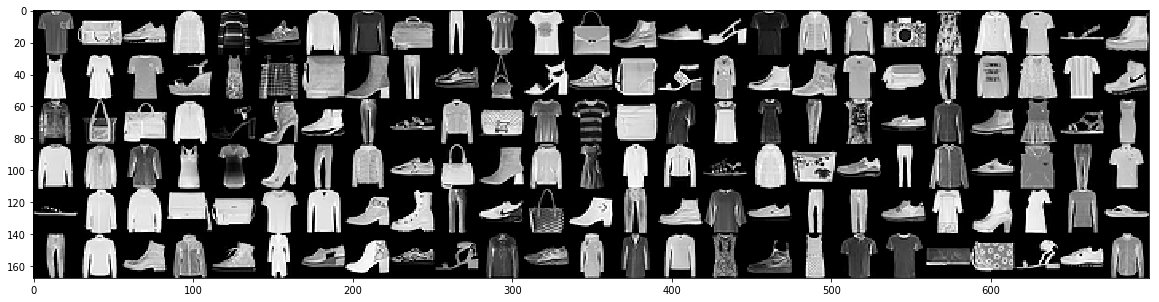

In [44]:
folder = '/Users/julianganzabal/.kaggle/competitions/fashion-mnist-itba-lab-ml/'
x_train, x_valid, y_train_categorical, y_val_categorical = get_FASHION_MNIST_data(folder)
plot_numbers(x_train.reshape(-1,28,28),range(150), columns=25, figsize=(20, 20))

## Preprocesamiento

- Limpiar datos
- Normalizar
- Reducción de parametros
- Transformación

## Antes de empezar a entrenar

- ¿Cual es la metrica que voy a utilizar para medir la performance del modelo?
- ¿Cual será la función de costo que voy a minimizar para entrenar el modelo?
- ¿Que arquitectura voy a utilizar?

## Nunca descartar un modelo simple
Nos da una cota inferior para modelos mas complejos

### Regresión logistica

In [56]:
output_size = 10
default_initializer = initializers.normal(mean=0, stddev=0.0001)
model_logistic = Sequential()
model_logistic.add(Flatten(input_shape=x_train.shape[1:]))
model_logistic.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_logistic.add(Activation('softmax'))
model_logistic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_46 (Activation)   (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


#### Desde donde parto?

In [57]:
optim = optimizers.adam()
model_logistic.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_logistic.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 8s 164us/step


[2.3981418685913085, 0.09922916666666666]

Que pasa si me equivoque y puse la funcion de costo equivocada y sin querelo estoy planteando un modelo multilabel?

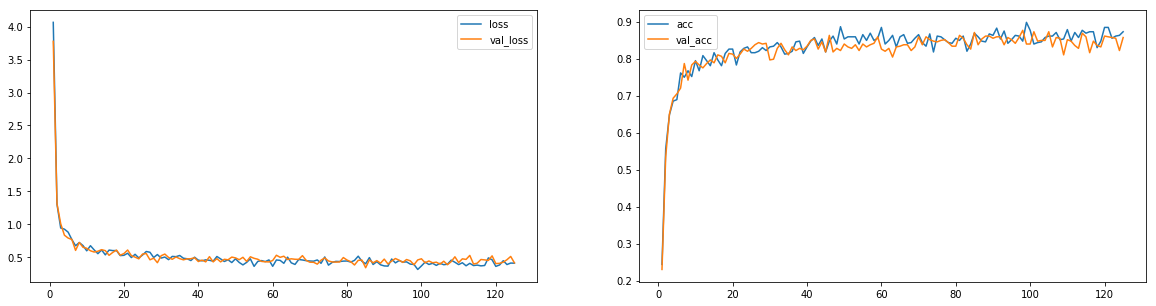

Epoch 00025: val_acc improved from 0.85033 to 0.85092, saving model to model_logistic.mnist.hdf5
48000/48000 [==============================] - 2s 32us/step - loss: 0.4096 - acc: 0.8583 - val_loss: 0.4315 - val_acc: 0.8509


In [87]:
lr = 0.00001
optim = optimizers.adam(lr=lr)
batch_size = 512
plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=20, 
                         val_samples=batch_size,
                         x_val=x_valid,
                         y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='model_logistic.mnist.hdf5', 
                               verbose=1, save_best_only=True, 
                               monitor='val_acc')
model_logistic.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_logistic.fit(x_train, 
                       y_train_categorical,
                       epochs=25, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [90]:
print(model_logistic.evaluate(x_train, y_train_categorical))
print(model_logistic.evaluate(x_valid, y_val_categorical))
print(model_logistic.evaluate(x_test, y_test))

48000/48000 [==============================] - 4s 73us/step
[0.40387504224479198, 0.8608958333333333]
12000/12000 [==============================] - 1s 73us/step
[0.43148914198080701, 0.85091666666666665]
10000/10000 [==============================] - 1s 83us/step
[0.47089867200851443, 0.83750000000000002]


In [91]:
model_logistic.load_weights('model_logistic.mnist.hdf5')
print(model_logistic.evaluate(x_train, y_train_categorical))
print(model_logistic.evaluate(x_valid, y_val_categorical))
print(model_logistic.evaluate(x_test, y_test))

48000/48000 [==============================] - 4s 78us/step
[0.40387504224479198, 0.8608958333333333]
12000/12000 [==============================] - 1s 74us/step
[0.43148914198080701, 0.85091666666666665]
10000/10000 [==============================] - 1s 74us/step
[0.47089867200851443, 0.83750000000000002]


## Luego de las primeras corridas
- Cual es la cota superior de performance (Bayes error)
- Human-level performance
- Train performance
- Bias Evitable (Avoidable Bias): Dif entre Human level (o Bayes) y Train

In [96]:
default_initializer = initializers.normal(mean=0, stddev=0.001)
model_hidden_1 = Sequential()
model_hidden_1.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Dense(100, kernel_initializer=default_initializer, name='Intermedia_1'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(400, kernel_initializer=default_initializer, name='Intermedia_2'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_3'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(400, kernel_initializer=default_initializer, name='Intermedia_4'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(Activation('relu'))
model_hidden_1.add(Dense(100, kernel_initializer=default_initializer, name='Intermedia_5'))
model_hidden_1.add(BatchNormalization())
model_hidden_1.add(LeakyReLU())
model_hidden_1.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_hidden_1.add(Activation('softmax'))
model_hidden_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_116 (Bat (None, 784)               3136      
_________________________________________________________________
Intermedia_1 (Dense)         (None, 100)               78500     
_________________________________________________________________
batch_normalization_117 (Bat (None, 100)               400       
_________________________________________________________________
activation_163 (Activation)  (None, 100)               0         
_________________________________________________________________
Intermedia_2 (Dense)         (None, 400)               40400     
_________________________________________________________________
batch_normalization_118 (Bat (None, 400)               1600      
__________

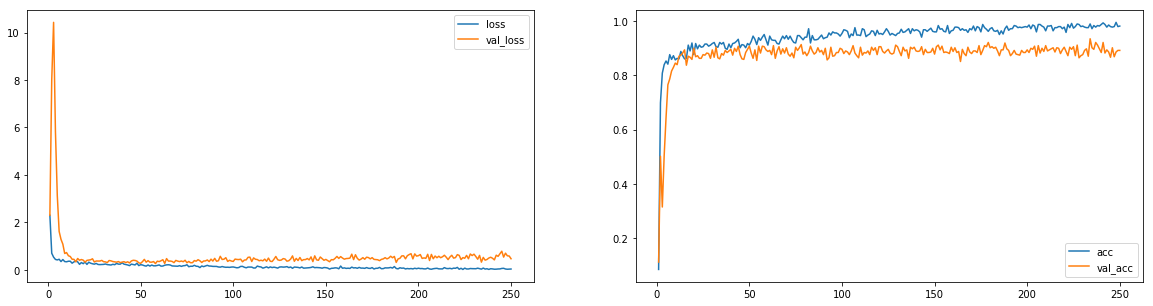

Epoch 00050: val_acc did not improve
48000/48000 [==============================] - 16s 327us/step - loss: 0.0459 - acc: 0.9831 - val_loss: 0.5638 - val_acc: 0.8932


In [97]:
lr = 0.01
optim = optimizers.adam(lr=lr)
batch_size = 512
plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=20, 
                         val_samples=batch_size,
                         x_val=x_valid,
                         y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='model_hidden_1.mnist.hdf5', verbose=1, save_best_only=True, monitor='val_acc')
model_hidden_1.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_hidden_1.fit(x_train, 
                       y_train_categorical,
                       epochs=50, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [98]:
print(model_hidden_1.evaluate(x_train, y_train_categorical))
print(model_hidden_1.evaluate(x_valid, y_val_categorical))
print(model_hidden_1.evaluate(x_test, y_test))

48000/48000 [==============================] - 15s 320us/step
[0.034511228667290804, 0.98787499999999995]
12000/12000 [==============================] - 4s 317us/step
[0.56378539610172929, 0.89324999999999999]
10000/10000 [==============================] - 3s 335us/step
[0.63504189453618598, 0.88109999999999999]


In [35]:
model_hidden_1.load_weights('model_hidden_1.mnist.hdf5')
print(model_hidden_1.evaluate(x_train, y_train_categorical))
print(model_hidden_1.evaluate(x_valid, y_val_categorical))
print(model_hidden_1.evaluate(x_test, y_test))

NameError: name 'model_hidden_1' is not defined

## Tenemos overfiting?

In [37]:
do_rate = 0.5
output_size = 10
default_initializer = initializers.normal(mean=0, stddev=0.001)
model_hidden_do = Sequential()
model_hidden_do.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Dense(100, kernel_initializer=default_initializer, name='Intermedia_1'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Activation('relu'))
model_hidden_do.add(Dropout(do_rate))
model_hidden_do.add(Dense(400, kernel_initializer=default_initializer, name='Intermedia_2'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Activation('relu'))
model_hidden_do.add(Dropout(do_rate))
model_hidden_do.add(Dense(800, kernel_initializer=default_initializer, name='Intermedia_3'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Activation('relu'))
model_hidden_do.add(Dense(400, kernel_initializer=default_initializer, name='Intermedia_4'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(Activation('relu'))
model_hidden_do.add(Dropout(do_rate))
model_hidden_do.add(Dense(100, kernel_initializer=default_initializer, name='Intermedia_5'))
model_hidden_do.add(BatchNormalization())
model_hidden_do.add(LeakyReLU())
model_hidden_do.add(Dropout(do_rate))
model_hidden_do.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_hidden_do.add(Activation('softmax'))
model_hidden_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 784)               3136      
_________________________________________________________________
Intermedia_1 (Dense)         (None, 100)               78500     
_________________________________________________________________
batch_normalization_44 (Batc (None, 100)               400       
_________________________________________________________________
activation_36 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
Intermedia_2 (Dense)         (None, 400)               40400     
__________

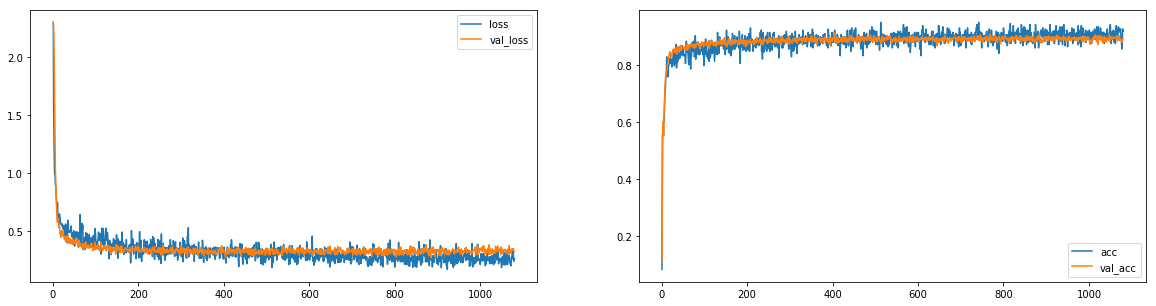

Epoch 00108: val_acc did not improve
48000/48000 [==============================] - 23s 473us/step - loss: 0.2569 - acc: 0.9082 - val_loss: 0.3315 - val_acc: 0.8903
Epoch 109/200
  768/48000 [..............................] - ETA: 43s - loss: 0.2703 - acc: 0.9036

/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.435360). Check your callbacks.
  % delta_t_median)
/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218298). Check your callbacks.
  % delta_t_median)


22784/48000 [=============>................] - ETA: 11s - loss: 0.2499 - acc: 0.9104

KeyboardInterrupt: 

In [38]:
lr = 0.001
optim = optimizers.adam(lr=lr)
batch_size = 256
plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=20, 
                         val_samples=2048,
                         x_val=x_valid,
                         y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='model_hidden_do.mnist.hdf5', verbose=1, save_best_only=True, monitor='val_acc')
model_hidden_do.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model_hidden_do.fit(x_train, 
                       y_train_categorical,
                       epochs=200, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [39]:
print(model_hidden_do.evaluate(x_train, y_train_categorical))
print(model_hidden_do.evaluate(x_valid, y_val_categorical))
print(model_hidden_do.evaluate(x_test, y_test))

48000/48000 [==============================] - 12s 258us/step
[0.14511168176929157, 0.94768750000000002]
12000/12000 [==============================] - 3s 263us/step
[0.32317728421588737, 0.89391666666666669]
10000/10000 [==============================] - 3s 259us/step
[0.34036448456645013, 0.88690000000000002]


In [41]:
model_hidden_do.load_weights('model_hidden_do.mnist.hdf5')
print(model_hidden_do.evaluate(x_train, y_train_categorical))
print(model_hidden_do.evaluate(x_valid, y_val_categorical))
print(model_hidden_do.evaluate(x_test, y_test))

48000/48000 [==============================] - 12s 251us/step
[0.16146961520177622, 0.9415]
12000/12000 [==============================] - 3s 263us/step
[0.31886622866988185, 0.89500000000000002]
10000/10000 [==============================] - 3s 266us/step
[0.33910048762559891, 0.88649999999999995]
